# Talktorial 8

# Protein data acquisition: Protein Data Bank (PDB)

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Anja Georgi and Majid Vafadar

## Aim of this talktorial

In this talktorial, we conduct the groundwork for the next talktorial where we will generate a ligand-based ensemble pharmacophore for EGFR. Therefore, we 
(i) fetch all PDB IDs for EGFR from the PDB database, 
(ii) retrieve five protein-ligand structures, which have the best structural quality and are derived from X-ray crystallography, and 
(iii) align all structures to each in 3D as well as extract and save the ligands to be used in the next talktorial.

## Learning Goals

### Theory
* Protein Data Bank (PDB)
* Python package PyPDB
 
### Practical

* Select query protein
* Get statistic on PDB entries for query protein
* Get all PDB IDs for query protein
* Get meta information on PDB entries
* Filter and sort meta information on PDB entries
* Get meta information of ligands from top structures
* Draw top ligand molecules
* Create protein-ligand ID pairs
* Get the PDB structure files
* Align PDB structures
 
## References

* Protein Data Bank 
([PDB website](http://www.rcsb.org/pdb>))
* PyPDB python package 
([<i>Bioinformatics</i> (2016), <b>32</b>, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543))
* PyPDB python package documentation 
([PyPDB website](http://www.wgilpin.com/pypdb_docs/html/))
* PyMol selection algebra 
([PyMolWiki: selection algebra](https://pymolwiki.org/index.php/Selection_Algebra))

## Theory

### Protein Data Bank (PDB)

The Protein Data Bank (PDB) is one of the most comprehensive structural biology information databases and a key resource in areas of structural biology, such as structural genomics and drug design. ([PDB website](http://www.rcsb.org/pdb>))

Structural data is generated from structural determination methods such as X-ray crystallography (most common method), nuclear magnetic resonance (NMR), and cryo electron microscopy (cryo-EM). 
For each entry, the database contains (i) the 3D coordinates of the atoms and the bonds connecting these atoms for proteins, ligand, cofactors, water molecules, and ions, as well as (ii) meta information on the structural data such as the PDB ID, the authors, the deposition date, the structural determination method used and the structural resolution.

The structural resolution is a measure of the quality of the data that has been collected and has the unit Å (Angström). The lower the value, the higher the quality of the structure. 

The PDB website offers the 3D visualization of the protein structures (with ligand interactions if available) and the structure quality metrics, as can be seen for the PDB entry of an example epidermal growth factor receptor (EGFR) with the [PDB ID 3UG5](https://www.rcsb.org/structure/3UG5).

<img src="./images/protein-ligand-complex.png" align="above" alt="Image cannot be shown" width="400">
<div align="center"> Figure 1: The protein structure (in gray) with an interacting ligand (in green) is shown for an example epidermal growth factor receptor (EGFR) with the PDB ID 3UG5 (figure by Dominique Sydow).</div>

### PyPDB

PyPDB is a python programming interface for the PDB and works exclusively in Python 3. 
This package facilitates the integration of automatic PDB searches within bioinformatics workflows and simplifies the process of performing multiple searches based on the results of existing searches. 
It also allows an advanced querying of information on PDB entries. 
The PDB currently uses a RESTful API that allows for the retrieval of information via standard HTML vocabulary. PyPDB converts these objects into XML strings. 
([<i>Bioinformatics</i> (2016), <b>32</b>, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543))

A list of functions is provided on the PyPDB documentation website ([PyPDB website](http://www.wgilpin.com/pypdb_docs/html/)).

## Practical

In [1]:
# Import necessary libraries
from pypdb import *
from pymol import *

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
IPythonConsole.ipython_useSVG=True

import pprint
import glob

import pandas as pd
from array import array
import numpy as np
import collections

import matplotlib.pyplot as plt
%matplotlib inline

### Select query protein

We use EGFR as query protein for this talktorial. The UniProt ID of EGFR is `P00533`, which will be used in the following to query the PDB database.

### Get statistic on PDB entries for query protein 

First, we ask the question: How many PDB entries are deposited in the PDB for EGFR per year and how many in total?

We can do a search on the [PDB website](http://www.rcsb.org/pdb>) with the search term `P00533`. 
In October 2018, the PDB returned 179 search results.

Using `pypdb`, we can find all deposition dates of EGFR structures from the PDB database. The number of deposited structures is needed to set the parameter `max_results` of the function `find_dates`.

In [2]:
# Note: Parameter max_results default is 100, which is too low for EGFR
# If max_results > maximal number of EGFR structures: error, 
# Therefore we checked beforehand how many results exist (#179)

# This database query may take a moment (minute to couple of minutes)
all_dates = find_dates("P00533", max_results=179)  

In [3]:
print("Number of EGFR structures found: " + str(len(all_dates)))

Number of EGFR structures found: 179


In [4]:
# Example of deposition dates
all_dates[:3]

['2002-03-28', '2002-06-17', '2002-06-17']

We extract the year from the deposition dates and calculate a depositions-per-year histogram.

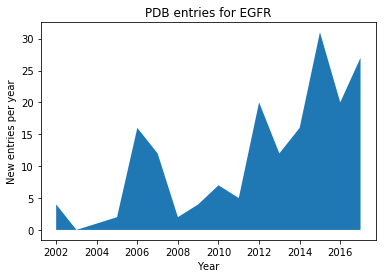

In [5]:
# Extract year
all_dates = np.asarray(all_dates)
all_years = np.asarray([int(depdate[:4]) for depdate in all_dates])

# Calculate histogram
bins = max(all_years)-min(all_years)  # Bin number = year range
subs_v_time = np.histogram(all_years, bins)

# All entries (excluding 2018) are plotted
dates, num_entries = subs_v_time[1][:-1], subs_v_time[0]  

# Show histogram
fig = plt.figure()
ax = plt.subplot(111)
ax.fill_between(dates, 0, num_entries)
ax.set_ylabel("New entries per year")
ax.set_xlabel("Year")
ax.set_title("PDB entries for EGFR")
plt.show()

### Get all PDB IDs for query protein

Now, we get all PDB structures for our query protein EGFR, using the `pypdb` function `make_query` and `do_search`.

In [6]:
search_dict = make_query("P00533")  # May run into timeout when max_results is 180 or more
found_pdb_ids = do_search(search_dict)

print("PDB IDs found for query: ")
print(found_pdb_ids)

print("\nNumber of structures: " + str(len(found_pdb_ids)))

PDB IDs found for query: 
['1IVO', '1M14', '1M17', '1MOX', '1XKK', '1YY9', '1Z9I', '2EB2', '2EB3', '2GS2', '2GS7', '2ITN', '2ITO', '2ITP', '2ITQ', '2ITT', '2ITU', '2ITV', '2ITW', '2ITX', '2ITY', '2ITZ', '2J5E', '2J5F', '2J6M', '2JIT', '2JIU', '2JIV', '2KS1', '2M0B', '2M20', '2N5S', '2RF9', '2RFD', '2RFE', '2RGP', '3B2U', '3B2V', '3BEL', '3BUO', '3C09', '3GOP', '3GT8', '3IKA', '3LZB', '3NJP', '3OB2', '3OP0', '3P0Y', '3PFV', '3POZ', '3QWQ', '3UG1', '3UG2', '3VJN', '3VJO', '3VRP', '3VRR', '3W2O', '3W2P', '3W2Q', '3W2R', '3W2S', '3W32', '3W33', '4G5J', '4G5P', '4HJO', '4I1Z', '4I20', '4I21', '4I22', '4I23', '4I24', '4JQ7', '4JQ8', '4JR3', '4JRV', '4KRL', '4KRM', '4KRO', '4KRP', '4LI5', '4LL0', '4LQM', '4LRM', '4R3P', '4R3R', '4R5S', '4RIW', '4RIX', '4RIY', '4RJ4', '4RJ5', '4RJ6', '4RJ7', '4RJ8', '4TKS', '4UIP', '4UV7', '4WD5', '4WKQ', '4WRG', '4ZAU', '4ZJV', '4ZSE', '5C8K', '5C8M', '5C8N', '5CAL', '5CAN', '5CAO', '5CAP', '5CAQ', '5CAS', '5CAU', '5CAV', '5CNN', '5CNO', '5CZH', '5CZI', '5D41

### Get meta information for PDB entries

We use `describe_pdb` to get meta information about the structures, which is stored per structure as dictionary.

Note: we only fetch meta information on PDB structures here, we do not fetch the structures (3D coordinates), yet.

In [7]:
# This database query may take a moment
pdbs = []
for i in found_pdb_ids:
  pdbs.append(describe_pdb(i))

pdbs[0]

{'relatedPDB': {'@pdbId': '1JL9',
  '@details': '1JL9 contains dymeric human EGF molecules.'},
 'structureId': '1IVO',
 'title': 'Crystal Structure of the Complex of Human Epidermal Growth Factor and Receptor Extracellular Domains.',
 'pubmedId': '12297050',
 'expMethod': 'X-RAY DIFFRACTION',
 'resolution': '3.30',
 'keywords': 'TRANSFERASE/SIGNALING PROTEIN',
 'nr_entities': '2',
 'nr_residues': '1350',
 'nr_atoms': '8813',
 'deposition_date': '2002-03-28',
 'release_date': '2002-10-16',
 'last_modification_date': '2011-07-13',
 'structure_authors': 'Ogiso, H., Ishitani, R., Nureki, O., Fukai, S., Yamanaka, M., Kim, J.H., Saito, K., Shirouzu, M., Yokoyama, S., RIKEN Structural Genomics/Proteomics Initiative (RSGI)',
 'citation_authors': 'Ogiso, H., Ishitani, R., Nureki, O., Fukai, S., Yamanaka, M., Kim, J.H., Saito, K., Inoue, M., Shirouzu, M., Yokoyama, S.',
 'status': 'CURRENT'}

### Filter and sort meta information on PDB entries

Since we want to use the information to filter for relevant PDB structures, we convert the data set from dictionary to DataFrame for easier handling.

In [8]:
pdbs = pd.DataFrame(pdbs)
pdbs

,citation_authors,deposition_date,expMethod,keywords,last_modification_date,nr_atoms,nr_entities,nr_residues,pubmedCentralId,pubmedId,relatedPDB,release_date,resolution,status,structureId,structure_authors,title
0,"Ogiso, H., Ishitani, R., Nureki, O., Fukai, S., Yamanaka, M., Kim, J.H., Saito, K., Inoue, M., Shirouzu, M., Yokoyama, S.",2002-03-28,X-RAY DIFFRACTION,TRANSFERASE/SIGNALING PROTEIN,2011-07-13,8813,2,1350,NaN,12297050,"{'@pdbId': '1JL9', '@details': '1JL9 contains dymeric human EGF molecules.'}",2002-10-16,3.30,CURRENT,1IVO,"Ogiso, H., Ishitani, R., Nureki, O., Fukai, S., Yamanaka, M., Kim, J.H., Saito, K., Shirouzu, M., Yokoyama, S., RIKEN Structural Genomics/Proteomics Initiative (RSGI)",Crystal Structure of the Complex of Human Epidermal Growth Factor and Receptor Extracellular Domains.
1,"Stamos, J., Sliwkowski, M.X., Eigenbrot, C.",2002-06-17,X-RAY DIFFRACTION,TRANSFERASE,2011-07-13,2452,1,333,NaN,12196540,"{'@pdbId': '1M17', '@details': 'Epidermal Growth Factor Receptor tyrosine kinase domain with 4-anilinoquinazoline inhibitor erlotinib'}",2002-09-04,2.60,CURRENT,1M14,"Stamos, J., Sliwkowski, M.X., Eigenbrot, C.",Tyrosine Kinase Domain from Epidermal Growth Factor Receptor
2,"Stamos, J., Sliwkowski, M.X., Eigenbrot, C.",2002-06-17,X-RAY DIFFRACTION,TRANSFERASE,2011-07-13,2540,1,333,NaN,12196540,"{'@pdbId': '1M14', '@details': 'Apo-form Epidermal Growth Factor Receptor kinase domain'}",2002-09-04,2.60,CURRENT,1M17,"Stamos, J., Sliwkowski, M.X., Eigenbrot, C.",Epidermal Growth Factor Receptor tyrosine kinase domain with 4-anilinoquinazoline inhibitor erlotinib
3,"Garrett, T.P.J., McKern, N.M., Lou, M., Elleman, T.C., Adams, T.E., Lovrecz, G.O., Zhu, H.-J., Walker, F., Frenkel, M.J., Hoyne, P.A., Jorissen, R.N., Nice, E.C., Burgess, A.W., Ward, C.W.",2002-09-10,X-RAY DIFFRACTION,transferase/growth factor,2011-07-13,8607,2,1102,NaN,12297049,"[{'@pdbId': '1IGR', '@details': '1IGR contains Equivalent froagment of Insulin-like Growth Factor Receptor'}, {'@pdbId': '1M6B', '@details': '1M6B contains ErbB3, homologous protein'}, {'@pdbId': '2TGF', '@details': '2TGF contains NMR structure the same protein, free ligand'}]",2003-09-10,2.50,CURRENT,1MOX,"Garrett, T.P.J., McKern, N.M., Lou, M., Elleman, T.C., Adams, T.E., Lovrecz, G.O., Zhu, H.-J., Walker, F., Frenkel, M.J., Hoyne, P.A., Jorissen, R.N., Nice, E.C., Burgess, A.W., Ward, C.W.",Crystal Structure of Human Epidermal Growth Factor Receptor (residues 1-501) in complex with TGF-alpha
4,"Wood, E.R., Truesdale, A.T., McDonald, O.B., Yuan, D., Hassell, A., Dickerson, S.H., Ellis, B., Pennisi, C., Horne, E., Lackey, K., Alligood, K.J., Rusnak, D.W., Gilmer, T.M., Shewchuk, L.",2004-09-29,X-RAY DIFFRACTION,TRANSFERASE,2011-07-13,2299,1,352,NaN,15374980,NaN,2004-12-07,2.40,CURRENT,1XKK,"Wood, E.R., Truesdale, A.T., McDonald, O.B., Yuan, D., Hassell, A., Dickerson, S.H., Ellis, B., Pennisi, C., Horne, E., Lackey, K., Alligood, K.J., Rusnak, D.W., Gilmer, T.M., Shewchuk, L.M.",EGFR kinase domain complexed with a quinazoline inhibitor- GW572016
5,"Li, S., Schmitz, K.R., Jeffrey, P.D., Wiltzius, J.J.W., Kussie, P., Ferguson, K.M.",2005-02-24,X-RAY DIFFRACTION,IMMUNE SYSTEM/Transferase,2011-07-13,8169,3,1058,NaN,15837620,"{'@pdbId': '1YY8', '@details': 'Fab fragment from the monoclonal antibody cetuximab'}",2005-04-26,2.61,CURRENT,1YY9,"Li, S., Schmitz, K.R., Jeffrey, P.D., Wiltzius, J.J.W., Kussie, P., Ferguson, K.M.",Structure of the extracellular domain of the epidermal growth factor receptor in complex with the Fab fragment of cetuximab/Erbitux/IMC-C225
6,"Choowongkomon, K., Carlin, C.R.",2005-04-02,SOLUTION NMR,TRANSFERASE,2011-07-13,439,1,53,NaN,15840573,NaN,2005-05-24,NaN,CURRENT,1Z9I,"Choowongkomon, K., Carlin, C.R., Sonnichsen, F.D.",A Structural Model for the Membrane-Bound Form of the Juxtamembrane Domain of the Epidermal Growth Factor Receptor
7,"Yoshikawa, S., Kukimoto-Niino, M., Parker, L., Handa, N., Terada, T., Fujimoto, T., Terazawa, Y., Wakiyama, M., Sato, M

In [9]:
print("Number of PDB structures for EGFR: " + str(len(pdbs)))

Number of PDB structures for EGFR: 179


We start filtering our dataset based on the following criteria:

#### 1. Experimental method: X-ray diffraction

We only keep structures resolved by `X-RAY DIFFRACTION`, the most commonly used structure determination method. 

In [10]:
pdbs = pdbs[pdbs.expMethod =="X-RAY DIFFRACTION"]
print("Number of PDB structures for EGFR from X-ray: " + str(len(pdbs)))

Number of PDB structures for EGFR from X-ray: 173


#### 2. Structural resolution

We only keep structures with a resolution equal or lower than 3 Å (Angström). The lower the resolution value, the higher is the quality of the structure (= the higher is the certainty that the assigned 3D coordinates of the atoms are correct). Below 3 Å, atomic orientations can be determined  and therefore is often used as threshold for structures relevant for structure-based drug design.

In [11]:
pdbs_resolution = [float(i) for i in pdbs.resolution.tolist()]
pdbs = pdbs[[i <= 3.0 for i in pdbs_resolution]]

print("Number of PDB structures for EGFR from X-ray with resolution <= 3.0 Angström: " + str(len(pdbs)))

Number of PDB structures for EGFR from X-ray with resolution <= 3.0 Angström: 140


We sort the data set by the structural resolution. 

In [12]:
pdbs = pdbs.sort_values(["resolution"], 
                        ascending=True, 
                        na_position='last')

We check the top PDB structures (sorted by resolution): 

In [13]:
pdbs.head()[["structureId", "resolution"]]

,structureId,resolution
153,5UG9,1.33
141,5HG8,1.42
152,5UG8,1.46
50,3POZ,1.50
139,5HG5,1.52


#### 3. Ligand-bound structures

Since we will create ensemble ligand-based pharmacophores in the next talktorial, we remove all PDB structures from our DataFrame, which do not contain a bound ligand: we use the `pypdb` function `get_ligands` to check/retrieve the ligand(s) from a PDB structure. PDB-annotated ligands can be ligands, cofactors, but also solvents and ions. In order to filter only ligand-bound structures, we (i) remove all structures without any annotated ligand and (ii) remove all structures that do not contain any ligands with a molecular weight (MW) greater than 100 Da (Dalton), since many solvents and ions weight less. Note: this is a simple, but not comprehensive exclusion of solvents and ions. 

In [14]:
# Get all PDB IDs from DataFrame
pdb_ids = pdbs["structureId"].get_values().tolist()

In [15]:
# Remove structures 
# (i) without ligand and 
# (ii) without any ligands with molecular weight (MW) greater than 100 Da (Dalton)

mw_cutoff = 100.0  # Molecular weight cutoff in Da

# This database query may take a moment
removed_pdb_ids = []
for i in pdb_ids:
    ligand_dict = get_ligands(i)
    
    # (i) Remove structure if no ligand present
    if ligand_dict["ligandInfo"] is None:
        pdb_ids.remove(i) # Remove ligand-free PDB IDs from list
        removed_pdb_ids.append(i) # Store ligand-free PDB IDs
    
    # (ii) Remove structure if not a single annotated ligand has a MW above mw_cutoff
    else:
        # Get ligand information
        ligs = ligand_dict["ligandInfo"]["ligand"]
        # Technicality: if only one ligand, cast dict to list (for the subsequent list comprehension)
        if type(ligs) == dict:
            ligs = [ligs]
        # Get MW per annotated ligand
        mw_list = [float(i["@molecularWeight"]) for i in ligs]
        # Remove structure if not a single annotated ligand has a MW above mw_cutoff
        if sum([mw > mw_cutoff for mw in mw_list]) == 0:
            pdb_ids.remove(i) # Remove ligand-free PDB IDs from list
            removed_pdb_ids.append(i) # Store ligand-free PDB IDs

print("PDB structures without a ligand (removed from our data set):")
print(removed_pdb_ids)

PDB structures without a ligand (removed from our data set):
['2EB2', '1M14', '3GOP', '2GS2', '5EDP', '2RFE', '4I1Z']


In [16]:
print("Number of structures with ligand: " + str(len(pdb_ids)))

Number of structures with ligand: 133


### Get meta information of ligands from top structures

In the next talktorial, we will build ligand-based ensemble pharmacophores from the top `top_num` structures with the highest resolution.

In [17]:
top_num = 4  # Number of top structures
pdb_ids = pdb_ids[0:top_num]
pdb_ids

['5UG9', '5HG8', '5UG8', '3POZ']

We fetch the PDB information about the top `top_num` ligands using `get_ligands`, to be stored as *csv* file (as dictionary per ligand).

If a structure contains several ligands, we select the largest ligand. Note: this is a simple, but not comprehensive method to select ligand binding the binding site of a protein. This approach may also select a cofactor bound to the protein. Therefore, please check the automatically selected top ligands in PyMol for further usage.

In [18]:
ligands_list = []

for i in pdb_ids:
    ligands = get_ligands(i)["ligandInfo"]["ligand"]
    # Technicality: if only one ligand, cast dict to list (for the subsequent list comprehension)
    if type(ligands) == dict:
        ligands = [ligands]

    weight = 0
    this_lig = {}
    
    # If several ligands contained, take largest
    for lig in ligands:
        if float(lig["@molecularWeight"]) > weight:
            this_lig = lig
            weight = float(lig["@molecularWeight"])
            
    ligands_list.append(this_lig)

# Change the format to DataFrame
ligs = pd.DataFrame(ligands_list)
ligs

,@chemicalID,@molecularWeight,@structureId,@type,InChI,InChIKey,chemicalName,formula,smiles
0,8AM,445.494,5UG9,non-polymer,"InChI=1S/C20H28FN9O2/c1-6-15(31)23-13-9-29(7-12(13)21)20-25-17(24-14-8-28(4)27-19(14)32-5)16-18(26-20)30(10-22-16)11(2)3/h8,10-13H,6-7,9H2,1-5H3,(H,23,31)(H,24,25,26)/t12-,13-/m1/s1",MJLFLAORJNTNDV-CHWSQXEVSA-N,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-1H-pyrazol-4-yl)amino]-9-(propan-2-yl)-9H-purin-2-yl}pyrrolidin-3-yl]propanamide",C20 H28 F N9 O2,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C(C)C)Nc4cn(nc4OC)C
1,634,377.4,5HG8,non-polymer,"InChI=1S/C19H19N7O2/c1-3-16(27)22-12-5-4-6-14(9-12)28-18-15-7-8-20-17(15)24-19(25-18)23-13-10-21-26(2)11-13/h4-11H,3H2,1-2H3,(H,22,27)(H2,20,23,24,25)",YWNHZBNRKJYHTR-UHFFFAOYSA-N,"N-[3-({2-[(1-methyl-1H-pyrazol-4-yl)amino]-7H-pyrrolo[2,3-d]pyrimidin-4-yl}oxy)phenyl]propanamide",C19 H19 N7 O2,CCC(=O)Nc1cccc(c1)Oc2c3cc[nH]c3nc(n2)Nc4cnn(c4)C
2,8BP,415.468,5UG8,non-polymer,"InChI=1S/C19H26FN9O/c1-5-15(30)24-14-9-28(8-13(14)20)19-25-17(23-12-6-22-27(4)7-12)16-18(26-19)29(10-21-16)11(2)3/h6-7,10-11,13-14H,5,8-9H2,1-4H3,(H,24,30)(H,23,25,26)/t13-,14-/m1/s1",CGULPICMFDDQRH-ZIAGYGMSSA-N,"N-[(3R,4R)-4-fluoro-1-{6-[(1-methyl-1H-pyrazol-4-yl)amino]-9-(propan-2-yl)-9H-purin-2-yl}pyrrolidin-3-yl]propanamide",C19 H26 F N9 O,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C(C)C)Nc4cnn(c4)C
3,03P,547.957,3POZ,non-polymer,"InChI=1S/C26H25ClF3N5O3/c1-25(2,37)14-22(36)31-9-11-35-10-8-20-23(35)24(33-15-32-20)34-17-6-7-21(19(27)13-17)38-18-5-3-4-16(12-18)26(28,29)30/h3-8,10,12-13,15,37H,9,11,14H2,1-2H3,(H,31,36)(H,32,33,34)",ZYQXEVJIFYIBHZ-UHFFFAOYSA-N,"N-{2-[4-({3-chloro-4-[3-(trifluoromethyl)phenoxy]phenyl}amino)-5H-pyrrolo[3,2-d]pyrimidin-5-yl]ethyl}-3-hydroxy-3-methylbutanamide",C26 H25 Cl F3 N5 O3,CC(C)(CC(=O)NCCn1ccc2c1c(ncn2)Nc3ccc(c(c3)Cl)Oc4cccc(c4)C(F)(F)F)O


In [19]:
ligs.to_csv('../data/T8/PDB_top_ligands.csv', header=True, index=False, sep='\t')

### Draw top ligand molecules

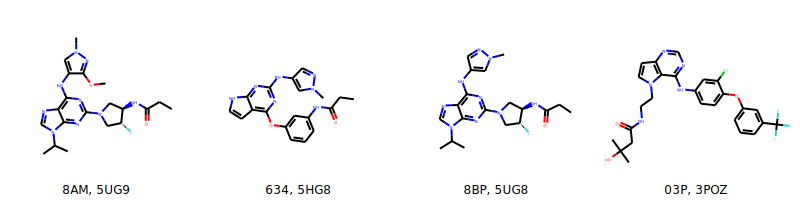

In [20]:
PandasTools.AddMoleculeColumnToFrame(ligs, 'smiles')
Draw.MolsToGridImage(mols=list(ligs.ROMol), 
                     legends=list(ligs['@chemicalID']+', '+ligs['@structureId']), 
                     molsPerRow=top_num)

### Create protein-ligand ID pairs

In [21]:
pairs = collections.OrderedDict()

for idx, row in ligs.iterrows():
    pairs[str(row['@structureId'])] = str(row['@chemicalID'])

print(pairs)

OrderedDict([('5UG9', '8AM'), ('5HG8', '634'), ('5UG8', '8BP'), ('3POZ', '03P')])


### Get the PDB structure files

We now fetch the PDB structure files, i.e. 3D coordinates of the protein, ligand (and if available other atomic or molecular entities such as cofactors, water molecules, and ions) from the PDB using the `pypdb` function `get_pdb_file`. 
Available file formats are *pdb* and *cif*, which store the 3D coordinations of atoms of the protein (and ligand, cofactors, water molecules, and ions) as well as information on bonds between atoms. Here, we work with *pdb* files.

In [22]:
# Fetch pdb file and save locally
for prot, lig in pairs.items():
    pdb_file = get_pdb_file(prot, filetype='pdb', compression=False)
    with open('../data/T8/'+ prot + '.pdb', 'w') as f:
        f.write(pdb_file)

### Align PDB structures

Since we want to build ligand-based ensemble pharmacophores in the next talktorial, it is necessary to align all structures to each other in 3D. We will use the molecular visualization program PyMol for this task, which can also be used from within the Jupyter notebook. PyMol aligns two structures at a time in a way that the distance of atoms between the two structures is minimized.

First, we will launch PyMol from the command line (in quiet mode, i.e. the GUI will not open).

In [23]:
# Launch PyMol in quiet mode
pymol.pymol_argv = ['pymol','-qc']
pymol.finish_launching()

For the alignment, we choose a reference structure file (immobile PDB, 'target') onto which the other ('query') structure files are superimposed using the PyMol command `cmd.align(query, target)`. All `cmd.` commands are commands for PyMol.

We save the aligned structures with the new coordinates as *pdb* files. We also extract the ligand from the structure file and save it separately as *pdb* file to be used in the next talktorial.

In [24]:
# Save alignment logs to file
f = open("../data/T8/alignments.log", "w")

# Variable distinguishing between immobile and mobile structure during alignment
immobile_pdb = True
refAlignTarget='non'
refAlignQuery='non'

# Align proteins on first protein
for prot, lig in pairs.items():
    
    # Immobile structure (reference structure for alignment)
    if immobile_pdb:
        target = prot
        f.write('Immobile target: ' + prot + '\n')
        
        # Load pdb file (complex of protein and ligand)
        targetFile = cmd.load('../data/T8/' + target + '.pdb')
        # Store name for refined alignment
        refAlignTarget='('+target+' within 5 of resn '+lig+')'
        
        # Save complex as pdb file
        cmd.save('../data/T8/' + target + '_algn.pdb', selection=target)
        
        # Select only the ligand with the selected name
        ligObj = cmd.select('ligand', target + ' and resn ' + lig)
        # Save selection as pdb file
        cmd.save('../data/T8/' + target + '_lig.pdb', selection='ligand', format='pdb')
        # Delete ligand selection
        cmd.delete(ligObj)
        # Target selected
        immobile_pdb = False
        
    # Mobile structures (which are aligned to reference structure)
    else:
        query = prot
        f.write('-- align %s to %s \n' %(query, target))
        
        # Load pdb file (complex of protein and ligand)
        queryFile = cmd.load('../data/T8/' + query + '.pdb')
        
        # Align structures (proteins) with focus on binding site
        refAlignQuery= '('+query+' within 5 of resn '+lig+')' 
        values = cmd.align(refAlignQuery, refAlignTarget)
        
        
        # If structures cannot be aligned (i.e. if RMSD > 5A), skip alignment
        if values[0] > 5:
            f.write('--- bad alignment: skip structure\n')
        else:
            # Save complex as pdb file
            cmd.save('../data/T8/' + query + '_algn.pdb', selection=query)
            
            # Select only the ligand
            ligObj = cmd.select('ligand', query + ' and resn ' + lig)
            
            # Save selection as pdb file
            cmd.save('../data/T8/' + query + '_lig.pdb', selection='ligand', format='pdb')
            
            # Delete ligand selection
            cmd.delete(ligObj)
            
        # Delete "query" selection
        cmd.delete(query)
    
# Delete "target" selection
cmd.delete(target)

f.close()

We quit the PyMol application.

In [25]:
# Quit PyMol
pymol.cmd.quit()

We check the existence of all ligand *pdb* files. If files are missing, please check the protein-ligand structures by hand in PyMol.

In [26]:
mol_files = []
for file in glob.glob("../data/T8/*_lig.pdb"):
    mol_files.append(file)
mol_files

['../data/T8/5UG9_lig.pdb',
 '../data/T8/3POZ_lig.pdb',
 '../data/T8/5HG8_lig.pdb',
 '../data/T8/5UG8_lig.pdb']

## Discussion

In this talktorial, we learned how to retrieve protein and ligand meta information and structural information from the PDB. We retained only X-ray structures and filtered our data by resolution and ligand availability. Ultimately, we aimed for an aligned set of ligands to be used in the next talktorial for the generation of ligand-based ensemble pharmacophores. 

In order to enrich information about ligands for pharmacophore modeling, it is advisable to not only filter by PDB structure resolution, but also to check for ligand diversity (see **talktorial 5** on molecule clustering by similarity) and to check for ligand activity (i.e. to include only potent ligands). 

## Quiz

1. Summarize the kind of data that the Protein Data Bank contains.
2. Explain what the resolution of a structure stands for and how and why we filter for it in this talktorial.
3. Explain what an alignment of structures means and discuss the alignment performed in this talktorial.